author: @SteveEckel

This little script tests the optical pumping from the optical Bloch equations
and rate equations.  It reproduces Fig. 5 of Ungar, P. J., Weiss, D. S., Riis,
E., & Chu, S., "Optical molasses and multilevel atoms: theory", *Journal of
the Optical Society of America B*, **6** (11), 2058 (1989).
http://doi.org/10.1364/JOSAB.6.002058

Note that there is a different defintion of the saturation parameters used in the
above paper than in this script.

Note that agreement between rate equations and the optical Bloch equations 
will only occur with the rate equations in the case of
a single laser beam.  This is because the rate equations assume that the
lasers are incoherent (their electric fields do not add to give twice the
amplitude) whereas the optical Bloch equations do.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.common import spherical2cart
import time
plt.style.use('paper')

transform = False # Change the variable to transform OBEs into re/im components.

### Let's define the laserBeams, Hamiltonian, and magnetic field
Note that one can
put the detuning on the laser or put the detuning on the Hamiltonian.
The latter appears to be faster.

In [2]:
# First the laser beams:
laserBeams = {}
laserBeams['$\\pi_z$']= pylcp.laserBeams([
    {'kvec': np.array([1., 0., 0.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'cartesian', 'delta':-2.73, 'beta':4*0.16}
    ])
laserBeams['$\\pi_y$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([0., 1., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73, 'beta':4*0.16}
    ])
laserBeams['$\\pi_x$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73, 'beta':0.16},
    {'kvec': np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':-2.73, 'beta':0.16}
    ])

# Then the magnetic field:
magField = lambda R: np.zeros(R.shape)

# Hamiltonian for F=2->F=3
gamma = 1
H_g, muq_g = pylcp.hamiltonians.singleF(F=2, gF=1, muB=1)
H_e, mue_q = pylcp.hamiltonians.singleF(F=3, gF=1, muB=1)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)
hamiltonian = pylcp.hamiltonian()
hamiltonian.add_H_0_block('g', H_g)
hamiltonian.add_H_0_block('e', H_e-0.*np.eye(H_e.shape[0]))
hamiltonian.add_d_q_block('g', 'e', d_q, gamma=gamma)

hamiltonian.print_structure()

[[(<g|H_0|g> 5x5) (<g|d_q|e> 5x7)]
 [(<e|d_q|g> 7x5) (<e|H_0|e> 7x7)]]


### Let's now make the rate equations and optical Bloch equations 
And using both, we will calculate the optical pumping from the Unager paper.

In [3]:
obe = {}
rateeq = {}
rateeq['$\\pi_z$'] = pylcp.rateeq(laserBeams['$\\pi_z$'], magField,
                                  hamiltonian)
obe['$\\pi_z$'] = pylcp.obe(laserBeams['$\\pi_z$'], magField, hamiltonian,
                            transform_into_re_im=transform)

# Run the rate equations:
N0 = np.zeros((rateeq['$\\pi_z$'].hamiltonian.n,))
N0[0] = 1
rateeq['$\\pi_z$'].set_initial_pop(N0)
rateeq['$\\pi_z$'].evolve_populations([0, 2*np.pi*600/gamma],
                                      max_step=1/gamma)

# Run the OBEs:
rho0 = np.zeros((obe['$\\pi_z$'].hamiltonian.n**2,))
rho0[0] = 1.
obe['$\\pi_z$'].set_initial_rho(np.real(rho0))
obe['$\\pi_z$'].evolve_density(t_span=[0, 2*np.pi*600/gamma],
                               progress_bar=True)

# Calculate the equilibrium populations:
Neq = rateeq['$\\pi_z$'].equilibrium_populations(np.array([0., 0., 0.]),
                                                 np.array([0., 0., 0.]), 0.)

Completed in 6.72 s.                                                  


Text(0, 0.5, '$\\rho_{ii}$')

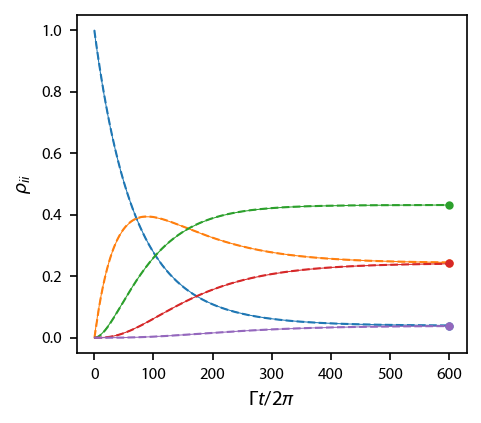

In [4]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(gamma*rateeq['$\\pi_z$'].sol.t/2/np.pi,
            rateeq['$\\pi_z$'].sol.y[jj, :], '--',
            color='C{0:d}'.format(jj),
            linewidth=1.0)
    ax.plot(gamma*obe['$\\pi_z$'].sol.t/2/np.pi, np.abs(obe['$\\pi_z$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
    ax.plot(gamma*obe['$\\pi_z$'].sol.t[-1]/2/np.pi, Neq[jj], '.', color='C{0:d}'.format(jj),
            linewidth=0.5)

ax.set_xlabel('$\\Gamma t/2\\pi$')
ax.set_ylabel('$\\rho_{ii}$')

### Check rotations

Next, we want to check that our rotations are working properly, so we will
run the same calculation for the $\hat{z}$ going beam with $\pi_y$ polarization.  But
before we even bother working with the OBE, we need to create the initial
state first, which involves rotating our state.

In [5]:
mug = spherical2cart(muq_g)
S = -mug

# What are the eigenstates of 'y'?
E, U = np.linalg.eig(S[1])

# Let's now define a rotation matrix that rotates us into the m_F basis alogn y:
inds = np.argsort(E)
E = E[inds]
U = U[:, inds]
Uinv = np.linalg.inv(U)

# In a positive magnetic field with g_F>0, I want the lowest eigenvalue. That
# corresponds to the -m_F state.
psi = U[:, 0]

# Now take that state and make the initial density matrix:
rho0 = np.zeros((hamiltonian.n, hamiltonian.n), dtype='complex128')
for ii in range(hamiltonian.ns[0]):
    for jj in range(hamiltonian.ns[0]):
        rho0[ii, jj] = psi[ii]*np.conjugate(psi[jj])

#Print out the density matrix (in z-basis), and the rotated density matrix (in y-basis):
#print(rho0[:5,:5])
#print(Uinv@rho0[:5,:5]@U)

# Evolve:
obe['$\\pi_y$'] = pylcp.obe(laserBeams['$\\pi_y$'], magField, hamiltonian,
                            transform_into_re_im=transform)
obe['$\\pi_y$'].set_initial_rho(rho0.reshape(hamiltonian.n**2,))
obe['$\\pi_y$'].evolve_density(t_span=[0, 2*np.pi*600],
                               progress_bar=True)

# Now rotate the denisty matrix back to be along $y$:
for jj in range(obe['$\\pi_y$'].sol.t.size):
    obe['$\\pi_y$'].sol.rho[:5, :5, jj] = Uinv@obe['$\\pi_y$'].sol.rho[:5, :5, jj]@U

Completed in 8.24 s.                                               


Now plot it up:

Text(0, 0.5, '$\\rho_{ii}$')

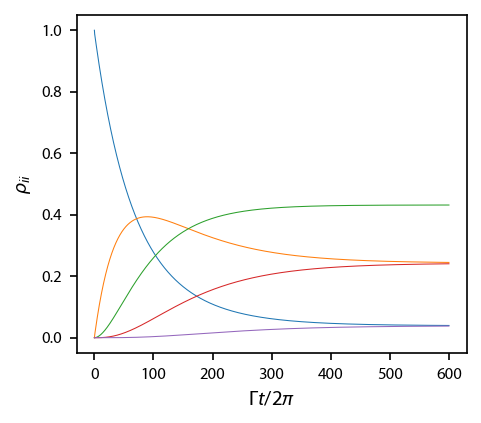

In [6]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(obe['$\\pi_y$'].sol.t/2/np.pi,
            np.abs(obe['$\\pi_y$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
ax.set_xlabel('$\\Gamma t/2\\pi$')
ax.set_ylabel('$\\rho_{ii}$')

Now, let's do the same thing for $\pi_x$, except this time we have two laser
beams, with 1/4 of the intensity:

In [7]:
# What are the eigenstates of 'y'?
E, U = np.linalg.eig(S[0])

inds = np.argsort(E)
E = E[inds]
U = U[:, inds]
Uinv = np.linalg.inv(U)

# In a positive magnetic field with g_F>0, I want the lowest eigenvalue. That
# corresponds to the -m_F state.
psi = U[:, 0]

rho0 = np.zeros((hamiltonian.n, hamiltonian.n), dtype='complex128')
for ii in range(hamiltonian.ns[0]):
    for jj in range(hamiltonian.ns[0]):
        rho0[ii, jj] = psi[ii]*np.conjugate(psi[jj])

obe['$\\pi_x$'] = pylcp.obe(laserBeams['$\\pi_x$'], magField, hamiltonian,
                            transform_into_re_im=transform)
obe['$\\pi_x$'].set_initial_rho(rho0.reshape(hamiltonian.n**2,))
obe['$\\pi_x$'].evolve_density(t_span=[0, 2*np.pi*600],
                               progress_bar=True)

for jj in range(obe['$\\pi_x$'].sol.t.size):
    obe['$\\pi_x$'].sol.rho[:5, :5, jj] = Uinv@obe['$\\pi_x$'].sol.rho[:5, :5, jj]@U

Completed in 8.47 s.                                               


Plot this up too:

Text(0, 0.5, '$\\rho_{ii}$')

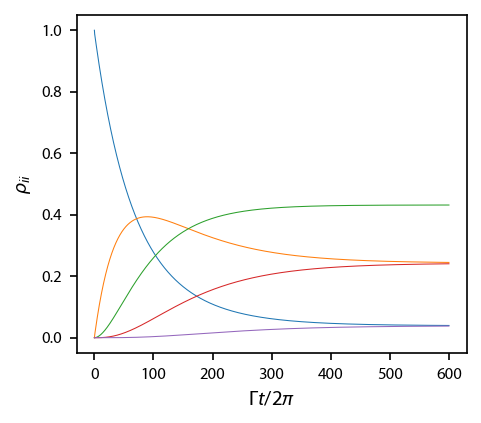

In [8]:
fig, ax = plt.subplots(1, 1)
for jj in range(5):
    ax.plot(obe['$\\pi_x$'].sol.t/2/np.pi,
            np.abs(obe['$\\pi_x$'].sol.rho[jj, jj]), '-',
            color='C{0:d}'.format(jj),
            linewidth=0.5)
ax.set_xlabel('$\\Gamma t/2\\pi$')
ax.set_ylabel('$\\rho_{ii}$')